<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/t_SNE_Scratch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Src: https://towardsdatascience.com/t-sne-from-scratch-ft-numpy-172ee2a61df7

In [12]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_mnist = pd.DataFrame(mnist["data"])
y = pd.DataFrame(mnist["target"])

X_mnist = X_mnist.sample(n=1000)
y_mnist = y.loc[X_mnist.index]
X = PCA(n_components=30).fit_transform(X_mnist)

In [2]:
import numpy as np
import warnings
import math

warnings.filterwarnings("ignore")

def get_gradient(p_ij: np.array([]),
                q_ij: np.array([]),
                Y: np.array([])):
    '''
    Obtain gradient of cost function at current point Y.
    '''

    n = len(p_ij)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0,n):

        # Equation 5
        diff = Y[i]-Y
        A = np.array([(p_ij[i,:] - q_ij[i,:])])
        B = np.array([(1+np.linalg.norm(diff,axis=1))**(-1)])
        C = diff
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

def get_symmetric_p_ij(p_ij:np.array([])):

    '''
    Function to obtain symmetric affinities matrix utilized in t-SNE.
    '''

    print("Computing Symmetric p_ij matrix....")

    n = len(p_ij)
    p_ij_symmetric = np.zeros(shape=(n,n))
    for i in range(0,n):
        for j in range(0,n):
            p_ij_symmetric[i,j] = (p_ij[i,j] + p_ij[j,i]) / (2*n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0,1)
    p_ij_symmetric = np.maximum(p_ij_symmetric,ε)

    print("Completed Symmetric p_ij Matrix. \n")

    return p_ij_symmetric

def get_low_dimensional_affinities(Y:np.array([])):
    '''
    Obtain low-dimensional affinities.
    '''

    n = len(Y)
    q_ij = np.zeros(shape=(n,n))

    for i in range(0,n):

        # Equation 4 Numerator
        diff = Y[i]-Y
        norm = np.linalg.norm(diff, axis=1)
        q_ij[i,:] = (1+norm**2)**(-1)

    # Set p = 0 when j = i
    np.fill_diagonal(q_ij, 0)

    # Equation 4
    q_ij = q_ij/q_ij.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0,1)
    q_ij = np.maximum(q_ij,ε)

    return q_ij

def initialization(X: np.array([]),
                   n_dimensions = 2,
                   initialization = 'random'):

    '''
    Obtain initial solution for t-SNE either randomly or using PCA.
    '''

    # Sample Initial Solution
    if initialization == 'random' or initialization != 'PCA':
        y0 = np.random.normal(loc=0,scale=1e-4,size=(len(X),n_dimensions))
    elif initialization == 'PCA':
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        y0 = X_centered @ Vt.T[:,:n_dimensions]

    return y0


def grid_search(diff_i, i, perplexity):

    '''
    Helper function to obtain σ's based on user-specified perplexity.
    '''

    result = np.inf # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm) # Use standard deviation of norms to define search space

    for σ_search in np.linspace(0.01*std_norm,5*std_norm,200):

        # Equation 1 Numerator
        p = np.exp(-norm**2/(2*σ_search**2))

        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0,1)
        p_new = np.maximum(p/np.sum(p),ε)

        # Shannon Entropy
        H = -np.sum(p_new*np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            σ = σ_search

    return σ


def get_original_pairwise_affinities(X:np.array([]),
                                     perplexity=10):

    '''
    Function to obtain affinities matrix.
    '''

    n = len(X)

    print("Computing Pairwise Affinities....")

    p_ij = np.zeros(shape=(n,n))
    for i in range(0,n):

        # Equation 1 numerator
        diff = X[i]-X
        σ_i = grid_search(diff, i, perplexity) # Grid Search for σ_i
        norm = np.linalg.norm(diff, axis=1)
        p_ij[i,:] = np.exp(-norm**2/(2*σ_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(p_ij, 0)

        # Equation 1
        p_ij[i,:] = p_ij[i,:]/np.sum(p_ij[i,:])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0,1)
    p_ij = np.maximum(p_ij,ε)

    print("Completed Pairwise Affinities Matrix. \n")

    return p_ij


def tsne(X: np.array([]),
        perplexity = 10,
        T = 1000,
        η = 200,
        early_exaggeration = 4,
        n_dimensions = 2):

    n = len(X)

    # Get original affinities matrix
    p_ij = get_original_pairwise_affinities(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = initialization(X, n_dimensions)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T-1):

        # Momentum & Early Exaggeration
        if t < 250:
            α = 0.5
            early_exaggeration = early_exaggeration
        else:
            α = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration*p_ij_symmetric, q_ij, Y[t])

        # Update Rule
        Y[t+1] = Y[t] - η * gradient + α * (Y[t] - Y[t-1]) # Use negative gradient

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}")
    solution = Y[-1]

    return solution, Y

In [6]:
X = np.array(X)
p_ij = get_original_pairwise_affinities(X)

Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 



In [7]:
p_ij_symmetric = get_symmetric_p_ij(p_ij)

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 



In [9]:
y0 = initialization(X,2,'random')
q_ij = get_low_dimensional_affinities(y0)
gradient = get_gradient(p_ij_symmetric,q_ij,y0)

In [10]:
solution, Y = tsne(X, perplexity = 10, T = 1000, η = 200, early_exaggeration = 4, n_dimensions = 2)

Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 4.4425941474234785
Iteration 50: Value of Cost Function is 2.68418447987947
Iteration 100: Value of Cost Function is 2.4299863712190404
Iteration 150: Value of Cost Function is 2.401922436146127
Iteration 200: Value of Cost Function is 2.3339252162939808
Iteration 250: Value of Cost Function is 2.3129266612701507
Iteration 300: Value of Cost Function is 1.2191899799247354
Iteration 350: Value of Cost Function is 1.128870137131877
Iteration 400: Value of Cost Function is 1.1016523017174502
Iteration 450: Value of Cost Function is 1.0889069118914865
Iteration 500: Value of Cost Function is 1.0811137936104636
Iteration 550: Value of Cost Function is 1.0758001664334338
Iteration 600: Value of Cost Function is 1.07193327904208
Iteration 650: Value of Cost Function is 1.

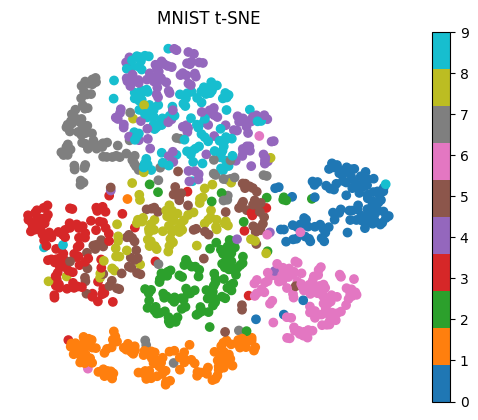

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
g1 = ax.scatter(solution[:, 0], solution[:, 1], c=y_mnist, cmap="tab10")
ax.axis('off')
ax.set_title('MNIST t-SNE')
plt.colorbar(g1,ax=ax)
plt.show()